In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from PIL import Image
%matplotlib inline

In [ ]:
!unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df26

# First glance

In [ ]:
# A function to load the input images and set its dimensions to 1024 x 768
def load_image(image_path):
    max_dim=512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)# decodes the image into a tensor
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]# broadcasting the image array so that it has a batch dimension

    return img

In [ ]:
def imshow(image, title=None):
    if(len(image.shape) > 3):# suppose dim is like 1,2,4,2,2,1... it removes the ones so that only 3 values remain W,H,c
        image=np.squeeze(image, axis=0)
    plt.imshow(image)
    if(title):# if there's a title mention it
        plt.title(title)

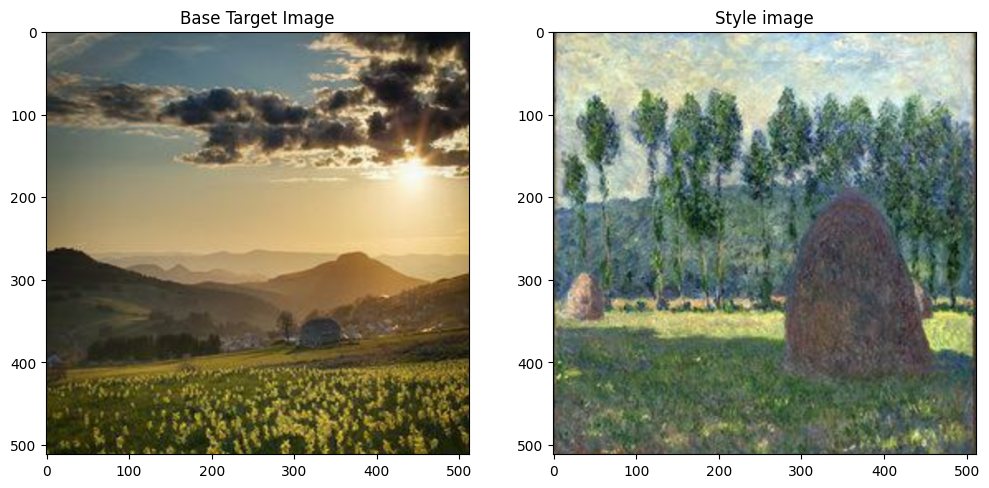

In [ ]:
# Let's see the images
content_img=load_image('/content/photo_jpg/00068bc07f.jpg')
style_img=load_image('/content/monet_jpg/2f90c99e10.jpg')

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
imshow(content_img, 'Base Target Image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style image')

In [ ]:
print(content_img.shape)
print(style_img.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [ ]:
# Define the content image representation and load the model
x=tf.keras.applications.vgg19.preprocess_input(content_img*255)# needs preprocessing for the model to be initialized
x=tf.image.resize(x, (256,256))# the vgg19 model takes images in 256
vgg_model=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable=False
vgg_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
# Chooose the content and style layers
content_layers=['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [ ]:
# Build the model
def my_model(layer_names):
    # Retrieve the output layers corresponding to the content and style layers
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg_model.input], outputs)
    return model

style_extractor = my_model(style_layers)
style_outputs = style_extractor(style_img*255)

In [ ]:
# Compute the gram matrix
# Einsum allows defining Tensors by defining their element-wise computation.
# This computation is defined by equation, a shorthand form based on Einstein summation.
def gram_matrix(input_tensor): # input_tensor is of shape ch, n_H, n_W
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # Unrolls n_H and n_W
    return result/(num_locations)

class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.vgg=my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False

    def call(self, inputs):
        inputs=inputs*255.0 # Scale back the pixel values
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)# Pass the preprocessed input to my_model

        # Separate the representations of style and content
        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        # Calculate the gram matrix for each layer in the style output. This will be the final style representation
        style_outputs=[gram_matrix(layer) for layer in style_outputs]

        # Store the content and style representation in dictionaries in a layer by layer manner
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}
        # Returns a dict of dicts with content and style representations, i.e., gram matrix of the style_layers and
        # the content of the content_layers

In [ ]:
# Now we extract the style and content features by calling the above class
extractor=entire_model(style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

results = extractor(tf.constant(content_img))

style_weight=40
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 0.7,
                 'block2_conv1': 0.19,
                 'block3_conv1': 0.24,
                 'block4_conv1': 0.11,
                 'block5_conv1': 0.26}
# style_weights = {'block1_conv1': 0.3,
#                  'block2_conv1': 0.45,
#                  'block3_conv1': 0.15,
#                  'block4_conv1': 0.05,
#                  'block5_conv1': 0.05}

In [ ]:
def total_cost(outputs):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    style_loss*=style_weight/len(style_layers)# Normalize

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss*=content_weight/len(content_layers)
    loss=style_loss+content_loss
    return loss

# Define a tf.Variable to contain the image to optimize
generate_image = tf.Variable(content_img)
# Since this is a float image, define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_cost(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

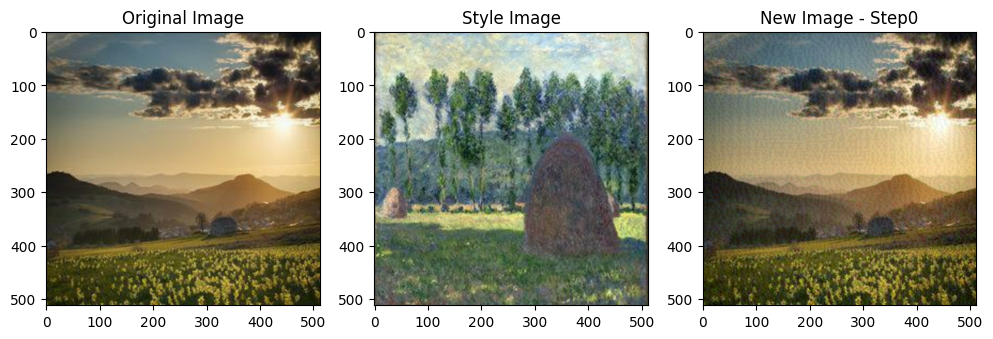

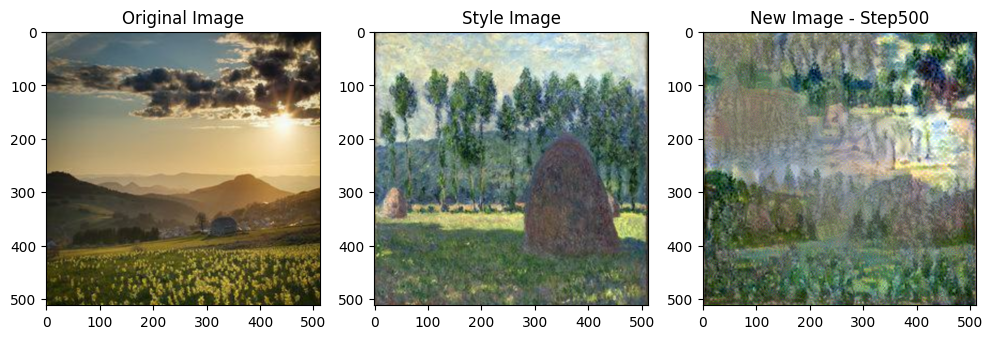

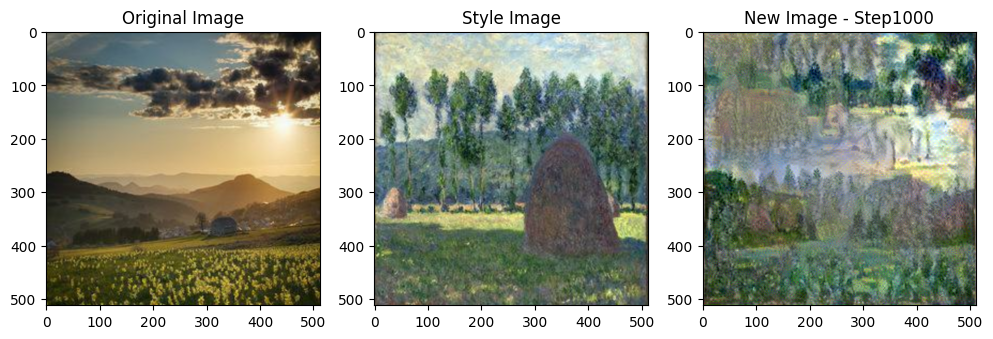

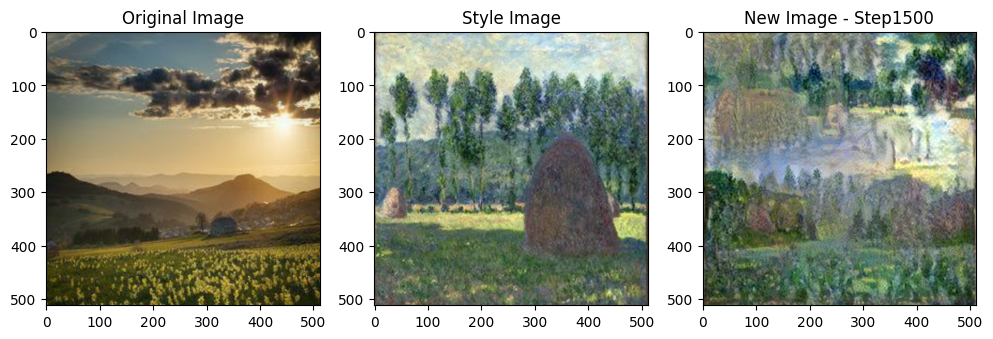

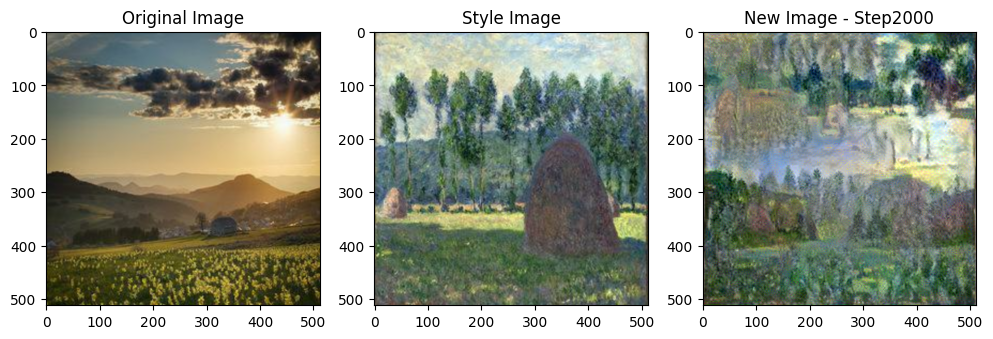

In [ ]:
num_iterations=2500
for i in range(num_iterations):
    train_step(generate_image)
    if(i%500==0):
        plt.figure(figsize=(12,12))
        plt.subplot(1, 3, 1)
        imshow(content_img, 'Original Image')
        plt.subplot(1, 3, 2)
        imshow(style_img, 'Style Image')
        plt.subplot(1, 3, 3)
        imshow(np.squeeze(generate_image.read_value(), 0), 'New Image - Step'+str(i))

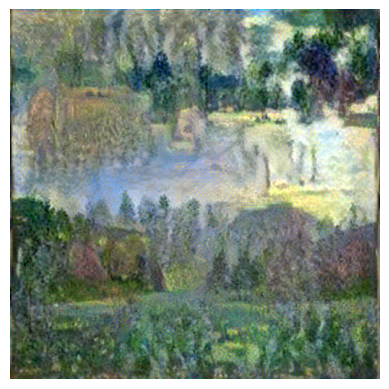

In [ ]:
train_step(generate_image)
plt.imshow(np.squeeze(generate_image.read_value(), 0))
plt.axis('off')
fig1 = plt.gcf()
fig1.savefig('new_image.png', bbox_inches='tight')

# Another approach

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import shutil
import itertools
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
BATCH_SIZE = 5
MONET_IMAGES_PATH = "/content/gan-getting-started/monet_jpg"
TEST_IMAGES_PATH = "/content/gan-getting-started/photo_jpg"

lr = 0.0001
beta1 = 0.5
beta2 = 0.996
n_epoches = 90
decay_epoch = 40
display_epoch = 25

In [ ]:
transforms_dataset = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, directory_x, directory_y, test=False, transforms=None):
        self.transforms = transforms

        if test:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[250:]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[250:301]]
        else:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[:250]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[:250]]

    def __len__(self):
        return len(self.monet_images_X)

    def __getitem__(self, index):
        x_img =  Image.open(self.monet_images_X[index])
        y_img =  Image.open(self.test_images_Y[index])

        if self.transforms is not None:
            x_img = self.transforms(x_img)
            y_img = self.transforms(y_img)
        return x_img, y_img

In [ ]:
train_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=False, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 3
)

test_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=True, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 3
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.scale_factor = 16

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels, 64, 2 * in_channels + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(64, in_channels, 2 * in_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

In [ ]:
G_XY = GeneratorResNet(3, num_residual_blocks=9)
D_Y = Discriminator(3)

G_YX = GeneratorResNet(3, num_residual_blocks=9)
D_X = Discriminator(3)

In [ ]:
# Check for CUDA availability and define the Tensor type accordingly
cuda_available = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_available else torch.Tensor
print(f'CUDA Available: {cuda_available}')

# Transfer models to CUDA if available
models = [G_XY, D_Y, G_YX, D_X]
for model in models:
    if cuda_available:
        model.cuda()

gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

In [ ]:
optimizer_G = torch.optim.Adam(itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
def learning_rate_decay(epoch, decay_start_epoch, total_epochs):
    if epoch < decay_start_epoch:
        return 1
    else:
        return 1 - (epoch - decay_start_epoch) / (total_epochs - decay_start_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))

In [ ]:
def sample_images(real_X, real_Y):
    G_XY.eval()
    G_YX.eval()

    real_X = real_X.type(Tensor)
    fake_Y = G_XY(real_X).detach()

    real_Y = real_Y.type(Tensor)
    fake_X = G_YX(real_Y).detach()

    ncols = real_X.size(0)
    real_X_grid = make_grid(real_X, nrow=ncols, normalize=True)
    fake_Y_grid = make_grid(fake_Y, nrow=ncols, normalize=True)
    real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
    fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    axs[0, 0].imshow(real_X_grid.permute(1, 2, 0).cpu())
    axs[0, 0].set_title("Real Images from Domain X")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(fake_Y_grid.permute(1, 2, 0).cpu())
    axs[0, 1].set_title("Generated Images to Domain Y")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(real_Y_grid.permute(1, 2, 0).cpu())
    axs[1, 0].set_title("Real Images from Domain Y")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(fake_X_grid.permute(1, 2, 0).cpu())
    axs[1, 1].set_title("Generated Images to Domain X")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)

In [ ]:
real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)

In [ ]:
for epoch in range(n_epoches):
    for i, (real_X, real_Y) in enumerate(train_loader):
        real_X, real_Y = real_X.type(Tensor), real_Y.type(Tensor)
        out_shape = [real_X.size(0), 1, real_X.size(2) // D_X.scale_factor, real_X.size(3) // D_X.scale_factor]

        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)

        # training generators
        G_XY.train()
        G_YX.train()

        optimizer_G.zero_grad()

        fake_Y = G_XY(real_X)
        fake_X = G_YX(real_Y)

        # identity loss
        loss_id_X = identity_loss(fake_Y, real_X)
        loss_id_Y = identity_loss(fake_X, real_Y)
        loss_identity = (loss_id_X + loss_id_Y) / 2

        # gan loss
        loss_GAN_XY = gan_loss(D_Y(fake_Y), valid)
        loss_GAN_YX = gan_loss(D_X(fake_X), valid)
        loss_GAN = (loss_GAN_XY + loss_GAN_YX) / 2

        # cycle loss
        recov_X = G_YX(fake_Y)
        recov_Y = G_XY(fake_X)

        loss_cycle_X = cycle_loss(recov_X, real_X)
        loss_cycle_Y = cycle_loss(recov_Y, real_Y)
        loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

        # total gan loss
        loss_G = 5.0 * loss_identity + loss_GAN + 10.0 * loss_cycle

        loss_G.backward()
        optimizer_G.step()

        #training discriminator X
        optimizer_D_X.zero_grad()

        loss_real = gan_loss(D_X(real_X), valid)
        loss_fake = gan_loss(D_X(fake_X.detach()), fake)
        loss_D_X = (loss_real + loss_fake) / 2

        loss_D_X.backward()
        optimizer_D_X.step()

        #training discriminator Y
        optimizer_D_Y.zero_grad()

        loss_real = gan_loss(D_Y(real_Y), valid)
        loss_fake = gan_loss(D_Y(fake_Y.detach()), fake)
        loss_D_Y = (loss_real + loss_fake) / 2

        loss_D_Y.backward()
        optimizer_D_Y.step()

    lr_scheduler_G.step()
    lr_scheduler_D_X.step()
    lr_scheduler_D_Y.step()

    # display results every 20 epoch
    if (epoch + 1) % display_epoch == 0:
        test_real_X, test_real_Y = next(iter(test_loader))
        sample_images(test_real_X, test_real_Y)

        loss_D = (loss_D_X + loss_D_Y) / 2
        print(f'[Epoch {epoch + 1} / {n_epoches}]')
        print(f'[Generator loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[Discriminator loss: {loss_D.item()} | D_X: {loss_D_X.item()} D_Y: {loss_D_Y.item()}]')

In [ ]:
files = [TEST_IMAGES_PATH + "/" + name for name in os.listdir(TEST_IMAGES_PATH)]
len(files)

In [ ]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
transforms_dataset = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

tensor_to_image = transforms.ToPILImage()
G_YX.eval()

# Process images in batches
for batch_start in range(0, len(files), BATCH_SIZE):
    batch_files = files[batch_start:batch_start + BATCH_SIZE]
    batch_imgs = [transforms_dataset(Image.open(file)) for file in batch_files]

    batch_tensor = torch.stack(batch_imgs).type(Tensor)
    generated_imgs = G_YX(batch_tensor).detach().cpu()

    for idx, tensor_img in enumerate(generated_imgs):
        # Convert tensor to numpy array and normalize to range [0, 255]
        np_img = tensor_img.squeeze().permute(1, 2, 0).numpy()
        np_img = ((np_img - np_img.min()) * 255 / (np_img.max() - np_img.min())).astype(np.uint8)

        # Save the generated image
        pil_img = tensor_to_image(np_img)
        _, filename = os.path.split(files[batch_start + idx])
        pil_img.save(os.path.join(save_dir, filename))

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Extra stuff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv('/content/nlp-getting-started/train.csv')

df.head()

In [ ]:
print('Number of tweets', len(df))

df['target'].plot(kind='hist')
plt.xticks([0, 1], [0, 1])
plt.show()

In [ ]:
def preprocessing_single_tweet(tweet):
    '''
    Basic preprocessing to remove:
    - web addresses
    - # from the words
    - words following @
    '''

    tweet = tweet.split(' ')
    new_tweet = ''

    for t in tweet:
        if len(t)>0:
            if t[0]!='@' and t[0:4]!='http' and t[0]!='#':
                new_tweet += t+ ' '
            elif t[0]=='#':
                new_tweet += t[1:]+ ' '
        else:
            pass

    return new_tweet


def preprocessing_all_tweets(tweets):
    tweets = np.array(tweets)

    new_tweets = []

    for tweet in tweets:
        new_tweets.append(preprocessing_single_tweet(tweet))

    return np.array(new_tweets)


new_tweets = preprocessing_all_tweets(df['text'])